In [3]:
import os, pdb

import argparse
import numpy as np
import torch
import requests
from PIL import Image
import sys
sys.path.append('pix2pix-zero/src')
sys.path.append('pix2pix-zero/src/utils')
from utils.ddim_inv import DDIMInversion
from utils.scheduler import DDIMInverseScheduler
from types import SimpleNamespace 
import matplotlib.pyplot as plt
from glob import glob
import argparse

cls = 'dog'
args = {
    'input_image': f'/grogu/user/akirchme/art3d_sd_webui/fg/{cls}/',
    'results_folder': f'/grogu/user/akirchme/art3d_sd_webui/inversion/{cls}',
    'num_ddim_steps': 100,
    'model_path': 'stabilityai/stable-diffusion-2-1-base',
    'use_float_16': False,
    'prompt': f'{cls}'
}

args = SimpleNamespace(**args)

torch_dtype = torch.float16 if args.use_float_16 else torch.float32   
pipe = DDIMInversion.from_pretrained(args.model_path, torch_dtype=torch_dtype).to("cuda")
pipe.scheduler = DDIMInverseScheduler.from_config(pipe.scheduler.config)
    
def generate_inversion(args):
    # make the output folders
    os.makedirs(args.results_folder, exist_ok=True)

    # if the input is a folder, collect all the images as a list
    if os.path.isdir(args.input_image):
        l_img_paths = sorted(glob(os.path.join(args.input_image, "*.png")))
    else:
        l_img_paths = [args.input_image]

    for img_path in l_img_paths:
        bname = os.path.basename(img_path).split(".")[0]
        res_path = os.path.join(args.results_folder, f"{bname}.pt")
        if os.path.exists(res_path):
            continue
        img = Image.open(img_path).resize((512,512), Image.Resampling.LANCZOS)
        res = pipe(
            args.prompt, 
            guidance_scale=1,
            num_inversion_steps=args.num_ddim_steps,
            img=img,
            torch_dtype=torch_dtype,
            return_intermediate=True
        )
        # save the inversion
        torch.save(res, res_path)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

In [4]:
generate_inversion(args)

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_111513/2058131129.py:1 in <module>                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_111513/2058131129.py'                       │
│                                                                                                  │
│ /tmp/ipykernel_111513/371180960.py:50 in generate_inversion                                      │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_111513/371180960.py'                        │
│                                                                                                  │
│ /home/akirchme/art3d/art3d-multiviewdepthdiffusion/ddim_inversion/pix2pix-zero/src/utils/ddim_in │
│ v.py:114 in __call__                                                                             │
│                                                                                                  │
│   111 │   │   │   │   │   if lambda_ac>0:                                                        │
│   112 │   │   │   │   │   │   for _inner in range(num_ac_rolls):                                 │
│   113 │   │   │   │   │   │   │   _var = torch.autograd.Variable(e_t.detach().clone(), require   │
│ ❱ 114 │   │   │   │   │   │   │   l_ac = self.auto_corr_loss(_var)                               │
│   115 │   │   │   │   │   │   │   l_ac.backward()                                                │
│   116 │   │   │   │   │   │   │   _grad = _var.grad.detach()/num_ac_rolls                        │
│   117 │   │   │   │   │   │   │   e_t = e_t - lambda_ac*_grad                                    │
│                                                                                                  │
│ /home/akirchme/art3d/art3d-multiviewdepthdiffusion/ddim_inversion/pix2pix-zero/src/utils/ddim_in │
│ v.py:28 in auto_corr_loss                                                                        │
│                                                                                                  │
│    25 │   │   │   while True:                                                                    │
│    26 │   │   │   │   if random_shift: roll_amount = randrange(noise.shape[2]//2)                │
│    27 │   │   │   │   else: roll_amount = 1                                                      │
│ ❱  28 │   │   │   │   reg_loss += (noise*torch.roll(noise, shifts=roll_amount, dims=2)).mean()   │
│    29 │   │   │   │   reg_loss += (noise*torch.roll(noise, shifts=roll_amount, dims=3)).mean()   │
│    30 │   │   │   │   if noise.shape[2] <= 8:                                                    │
│    31 │   │   │   │   │   break                                                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [7]:
bname = os.path.basename(f'{args.input_image}/1.pt').split(".")[0]
x_inv = torch.load(os.path.join(args.results_folder, f"{bname}.pt"))

In [14]:
{os.path.basename(x) : torch.load(x).shape for x in list(sorted(glob(os.path.join(args.results_folder, "*.pt"))))}

{'0.pt': torch.Size([1001, 4, 64, 64]),
 '1.pt': torch.Size([101, 4, 64, 64]),
 '1000.pt': torch.Size([1001, 4, 64, 64]),
 '1001.pt': torch.Size([1001, 4, 64, 64]),
 '1002.pt': torch.Size([1001, 4, 64, 64]),
 '1008.pt': torch.Size([1001, 4, 64, 64]),
 '1009.pt': torch.Size([1001, 4, 64, 64]),
 '101.pt': torch.Size([1001, 4, 64, 64]),
 '1015.pt': torch.Size([1001, 4, 64, 64]),
 '1016.pt': torch.Size([1001, 4, 64, 64]),
 '1017.pt': torch.Size([1001, 4, 64, 64]),
 '1022.pt': torch.Size([1001, 4, 64, 64]),
 '1023.pt': torch.Size([1001, 4, 64, 64]),
 '1024.pt': torch.Size([1001, 4, 64, 64]),
 '103.pt': torch.Size([1001, 4, 64, 64]),
 '1030.pt': torch.Size([1001, 4, 64, 64]),
 '1031.pt': torch.Size([1001, 4, 64, 64]),
 '1037.pt': torch.Size([1001, 4, 64, 64]),
 '1038.pt': torch.Size([1001, 4, 64, 64]),
 '1039.pt': torch.Size([1001, 4, 64, 64]),
 '1044.pt': torch.Size([1001, 4, 64, 64]),
 '1045.pt': torch.Size([1001, 4, 64, 64]),
 '1046.pt': torch.Size([1001, 4, 64, 64]),
 '1051.pt': torch.Si

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


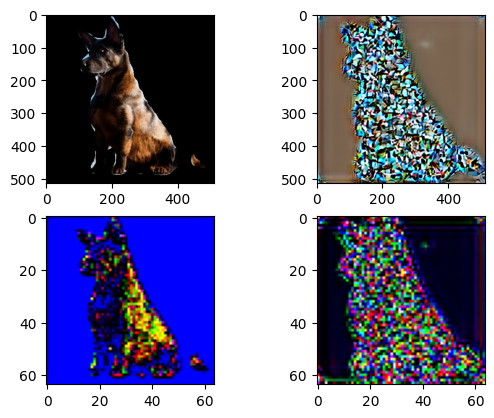

In [10]:
fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(pipe.decode_latents(x_inv[0:1].cuda()).squeeze())
axs[0,1].imshow(pipe.decode_latents(x_inv[-1:].cuda()).squeeze())
axs[1,0].imshow(x_inv[0,:3,:,:].permute(1,2,0))
axs[1,1].imshow(x_inv[-1,:3,:,:].permute(1,2,0))